#  GMM

Bu ödevde, UC Irvine Machine Learning Repository'den kalp hastalığı verisi ile çalışacaksınız.

Veri seti kümeleme algoritmasına geçmeden önce bazı işlemlere ihtiyaç duymaktadır.

#Değişkenleri belirleme
  X = heartdisease_df.iloc[:, :13]
  y = heartdisease_df.iloc[:, 13]

#"?" işareti olan değerleri 0 ile değiştirme 
  X = X.replace(to_replace='?', value=0)

#Hedef değişkeni 1 ve 0 olarak değiştirme? 
  y = np.where(y > 0, 0, 1)
Burada, X sizin değişkenleriniz olacak ve y içinde etiketleri tutuyoruz. Y, 1'e eşitse, hastanın kalp hastası olduğu ve y 0'a eşit olduğunda, hastanın kalp hastalığı olmadığı sonucuna varıyoruz.



Ödevi tamamlamak için aşağıdaki soruların cevabını içeren Jupyter notebook'u sisteme yükleyiniz:

- n_components = 2 olarak ayarlayarak kalp hastalığı verilerine GMM uygulayın. Çözümünüz için ARI ve siluet skorlarına bakın ve önceki derslerde k-means ve hiyerarşik kümeleme çözümleriyle karşılaştırın. Hangi algoritma daha iyi performans gösteriyor?

- Scikit-learn ile GMM uygulanırken kullanılan parametrelerden biri de covariance_type'dir. Bu parametre, kullanılacak kovaryans parametrelerinin türünü belirler. Özellikle, belirtebileceğiniz dört tür vardır:

1. full: Bu varsayılandır. Her bileşenin kendi genel kovaryans matrisi vardır.
2. tied: Tüm bileşenler aynı genel kovaryans matrisini paylaşır.
3. diag: Her bir bileşenin kendi çapraz kovaryans matrisi vardır.
4. spherical: Her bir bileşenin kendine ait tek bir varyansı vardır.

Bunları deneyin. Hangisi ARI ve siluet skorları açısından daha iyi performans gösteriyor?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

heartdisease_df = pd.read_csv('cleveland-0_vs_4.csv')

In [2]:
for i in ["ca", "thal", "num"]:
    print(f"{i} Column values:\n {heartdisease_df[i].unique()}\n")

ca Column values:
 ['0.0' '2.0' '1.0' '3.0' '<null>']

thal Column values:
 ['6.0' '3.0' '7.0' '<null>']

num Column values:
 ['negative' 'positive']



In [3]:
# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
heartdisease_df.num = heartdisease_df.num.replace('negative', 0)
heartdisease_df.num = heartdisease_df.num.replace('positive', 1)

In [4]:
print(heartdisease_df.loc[heartdisease_df['ca'] == '<null>'])
print(heartdisease_df.loc[heartdisease_df['thal'] == '<null>'])

      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
85   52.0  1.0  3.0     138.0  223.0  0.0      0.0    169.0    0.0      0.0   
142  58.0  1.0  2.0     125.0  220.0  0.0      0.0    144.0    0.0      0.4   
146  38.0  1.0  3.0     138.0  175.0  0.0      0.0    173.0    0.0      0.0   

     slope      ca thal  num  
85     1.0  <null>  3.0    0  
142    2.0  <null>  7.0    0  
146    1.0  <null>  3.0    0  
     age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
44  53.0  0.0  3.0     128.0  216.0  0.0      2.0    115.0    0.0      0.0   

    slope   ca    thal  num  
44    1.0  0.0  <null>    0  


In [5]:
heartdisease_df = heartdisease_df.drop([44,85,142,146])

In [6]:
heartdisease_df = heartdisease_df.dropna()
heartdisease_df.drop(heartdisease_df.tail(1).index,inplace=True)

In [7]:
heartdisease_df = heartdisease_df.reset_index(drop=True)

In [8]:
heartdisease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       172 non-null    float64
 1   sex       172 non-null    float64
 2   cp        172 non-null    float64
 3   trestbps  172 non-null    float64
 4   chol      172 non-null    float64
 5   fbs       172 non-null    float64
 6   restecg   172 non-null    float64
 7   thalach   172 non-null    float64
 8   exang     172 non-null    float64
 9   oldpeak   172 non-null    float64
 10  slope     172 non-null    float64
 11  ca        172 non-null    object 
 12  thal      172 non-null    object 
 13  num       172 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 18.9+ KB


In [9]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## Soru1 
n_components = 2 olarak ayarlayarak kalp hastalığı verilerine GMM uygulayın. Çözümünüz için ARI ve siluet skorlarına bakın ve önceki derslerde k-means ve hiyerarşik kümeleme çözümleriyle karşılaştırın. Hangi algoritma daha iyi performans gösteriyor?

In [10]:
gmm_cluster = GaussianMixture(n_components=2, random_state=123)
clusters = gmm_cluster.fit_predict(X_std)

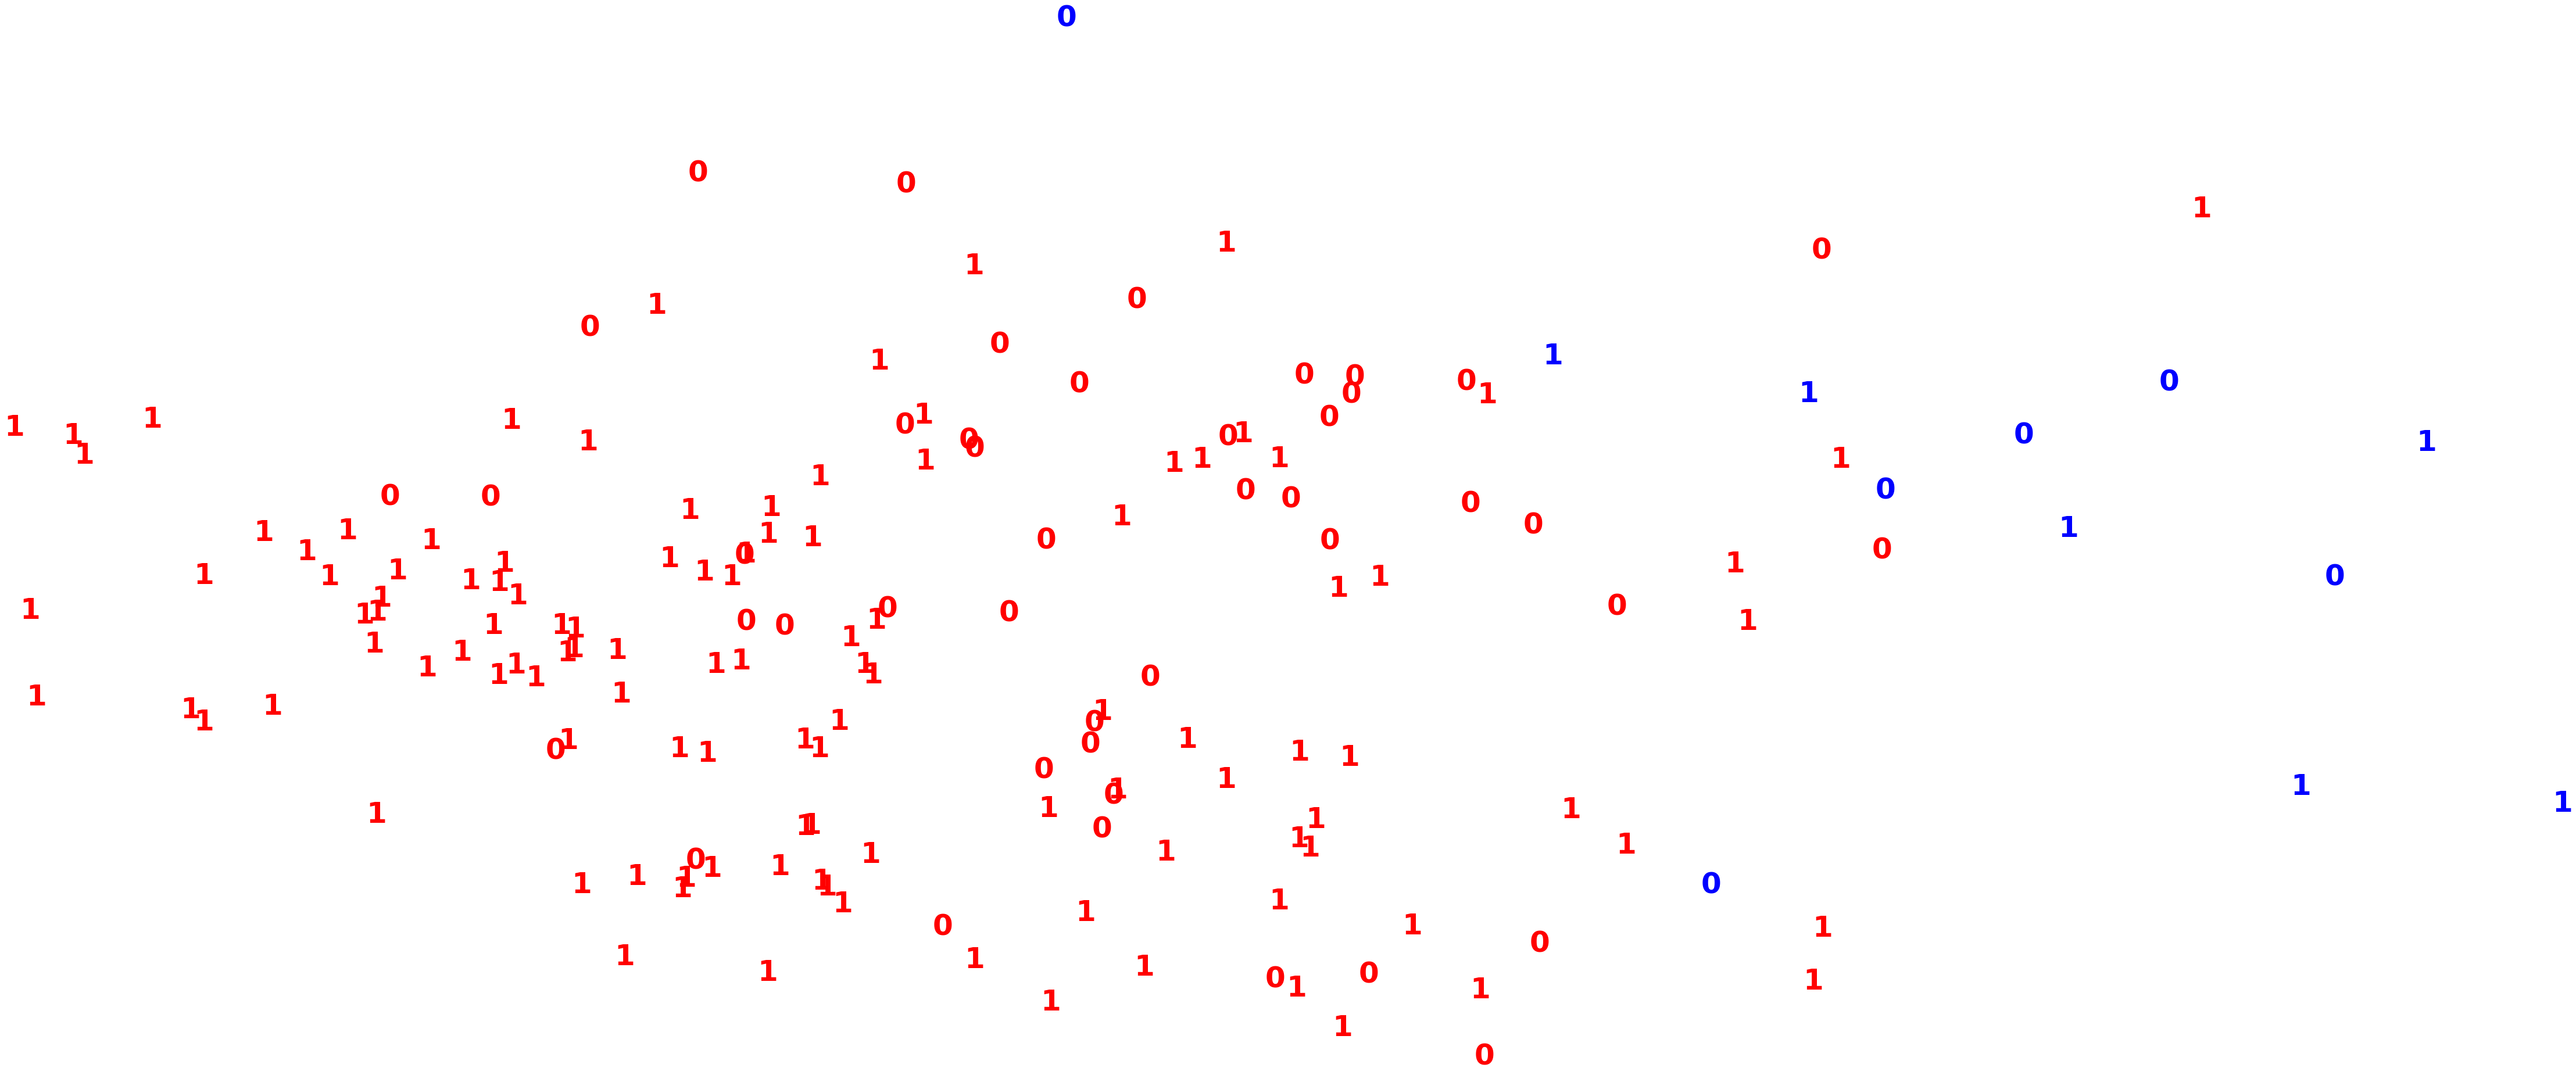

In [11]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [12]:
clusters = np.array([2 if x == 1 else 1 if x==0 else 0 for x in clusters])

pd.crosstab(y,clusters)

col_0,1,2
num,,
0,44,116
1,6,6


In [13]:
print("GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("GMM çözümünün siluet skoru                  : {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): 0.051
GMM çözümünün siluet skoru                  : 0.142


Hiyerarşik Kümeleme en iyi skoru veren compete idi;

- Yığınsal Kümeleme Sonuçlarının Ayarlanmış Rand Endeksi: 0.076
- Yığınsal Kümeleme Sonuçlarının silhoutte scoru: 0.113

GMM ile kıyasladığımızda en yüksek Düzeltilmiş Rand Endeksi(ARI) değerini **Compete Hiyerarşik Kümeleme** vermiştir.

# Soru2
Scikit-learn ile GMM uygulanırken kullanılan parametrelerden biri de covariance_type'dir. Bu parametre, kullanılacak kovaryans parametrelerinin türünü belirler. Özellikle, belirtebileceğiniz dört tür vardır:

1. full: Bu varsayılandır. Her bileşenin kendi genel kovaryans matrisi vardır.
2. tied: Tüm bileşenler aynı genel kovaryans matrisini paylaşır.
3. diag: Her bir bileşenin kendi çapraz kovaryans matrisi vardır.
4. spherical: Her bir bileşenin kendine ait tek bir varyansı vardır.

Bunları deneyin. Hangisi ARI ve siluet skorları açısından daha iyi performans gösteriyor?

In [15]:
#full
gmm_cluster1 = GaussianMixture(n_components=2, random_state=123, covariance_type='full')
clusters1 = gmm_cluster1.fit_predict(X_std)

print("GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters1)))
print("GMM çözümünün siluet skoru                  : {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters1, metric='euclidean')))

GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): 0.051
GMM çözümünün siluet skoru                  : 0.142


In [16]:
#tied
gmm_cluster2 = GaussianMixture(n_components=2, random_state=123, covariance_type='tied')
clusters2 = gmm_cluster2.fit_predict(X_std)

print("GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters2)))
print("GMM çözümünün siluet skoru                  : {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters2, metric='euclidean')))

GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): 0.103
GMM çözümünün siluet skoru                  : 0.142


In [19]:
#diag
gmm_cluster3 = GaussianMixture(n_components=2, random_state=123, covariance_type='diag')
clusters3 = gmm_cluster3.fit_predict(X_std)

print("GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters3)))
print("GMM çözümünün siluet skoru                  : {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters3, metric='euclidean')))

GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): 0.050
GMM çözümünün siluet skoru                  : 0.103


In [20]:
#spherical
gmm_cluster4 = GaussianMixture(n_components=2, random_state=123, covariance_type='spherical')
clusters4 = gmm_cluster4.fit_predict(X_std)

print("GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters4)))
print("GMM çözümünün siluet skoru                  : {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters4, metric='euclidean')))

GMM çözümünün Düzeltilmiş Rand Endeksi (ARI): -0.008
GMM çözümünün siluet skoru                  : 0.110


Tied en iyi ARI ve siluet skorunu verdi.